# 利用量子神经网络对鸢尾花进行分类


`Linux` `CPU` `全流程` `初级` `中级` `高级`

## 概述

在本次案例中，我们将利用量子神经网络对鸢尾花进行分类。鸢尾花数据集包含150个样本的4个特征数据，分别为花萼长度、宽度和花瓣长度、宽度，这也样本分别属于鸢尾花的三个不同亚属。这里选择数据集中的前100个样本（包含2个鸢尾花品种），并对样本进行训练和预测。


## 导入鸢尾花数据集

In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
def generate_train_and_test(split=0.8,shuffle=True):
    iris=datasets.load_iris()
    data=iris.data[:100,:].astype(np.float32)
    data=preprocessing.minmax_scale(data)*2-1
    label=np.zeros(100).astype(int)
    label[50:]=1
    return train_test_split(data,label,train_size=split,shuffle=True)
train_x,test_x,train_y,test_y=generate_train_and_test()
print('train sample and feature shape: ',train_x.shape)

train sample and feature shape:  (80, 4)


初步探索探索数据集，我们画出各个特征以及种类的散点图。

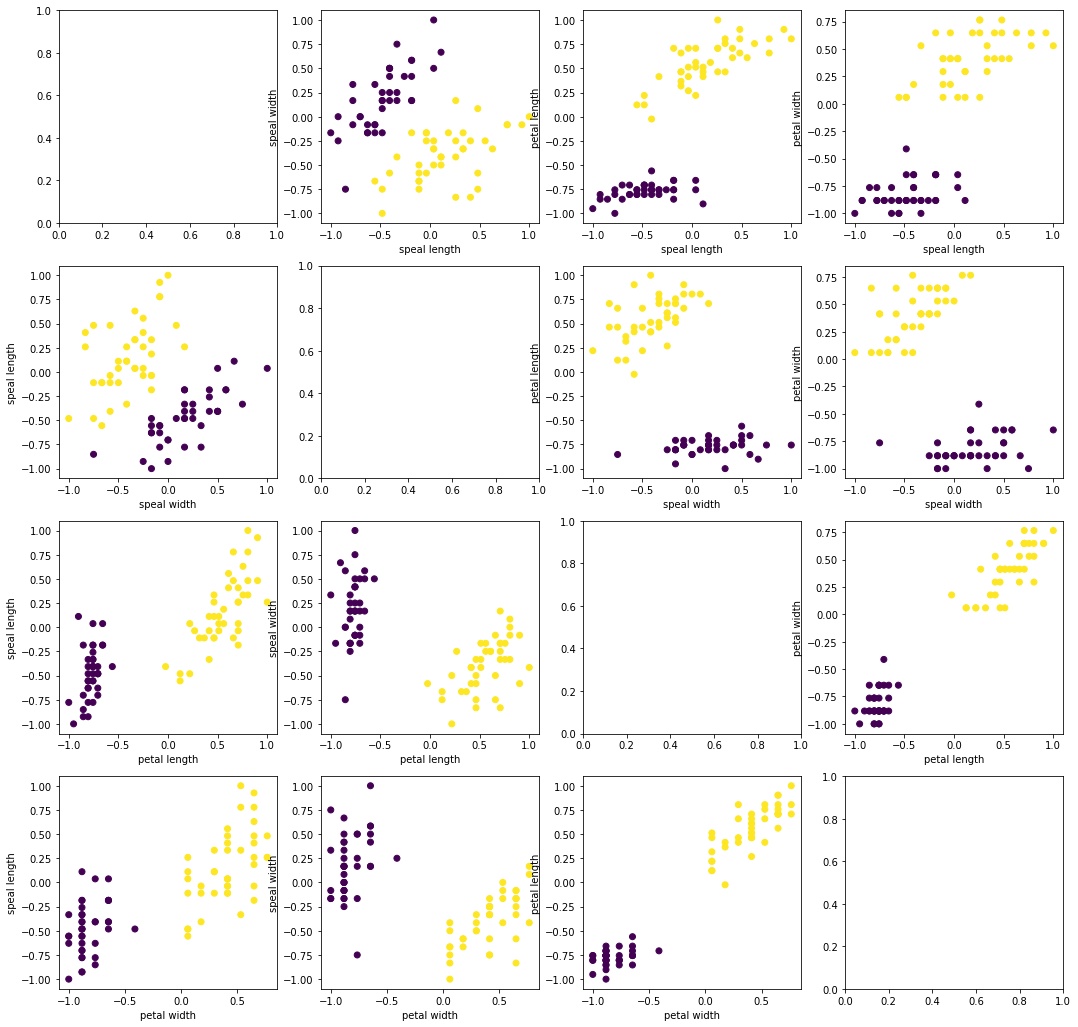

In [2]:
import matplotlib.pyplot as plt
feature_name={0:'speal length',1:'speal width',2:'petal length',3:'petal width'}
axs=plt.figure(figsize=(18,18)).subplots(4,4)
for i in range(4):
    for j in range(4):
        if i!=j:
            ax=axs[i][j]
            ax.scatter(train_x[:,i],train_x[:,j],c=train_y)
            ax.set_xlabel(feature_name[i])
            ax.set_ylabel(feature_name[j])
plt.show()

## 编码线路
我们搭建如下的量子神经网络来对将经典数据编码到量子态上

![encoder](./images/iris_encoder.png)

In [3]:
from mindquantum import H, RZ, RX, X, Circuit
def encoder(n):
    c = Circuit([H.on(i) for i in range(n)])
    for i in range(n):
        c += RZ(f'x{i}').on(i)
    for i in range(n - 1):
        c += X.on(i + 1, i)
        c += RZ(f'x{i},{i+1}').on(i + 1)
        c += X.on(i + 1, i)
    return c
enc=encoder(4).no_grad()
enc

/home/xuxs/gitee/mindquantum/mindquantum/__init__.py:49: UserWarning: [NOTE] Current simulator thread is 2. If your simulation is slow, set OMP_NUM_THREADS to a appropriate number according to your model.
  omp_num_threads))


H(0)
H(1)
H(2)
H(3)
RZ(x0|0)
RZ(x1|1)
RZ(x2|2)
RZ(x3|3)
X(1 <-: 0)
RZ(x0,1|1)
X(1 <-: 0)
X(2 <-: 1)
RZ(x1,2|2)
X(2 <-: 1)
X(3 <-: 2)
RZ(x2,3|3)
X(3 <-: 2)

## 待训练线路
待训练线路的搭建如下

![ansatz](./images/iris_ansatz.png)

In [4]:
from mindquantum.ansatz import HardwareEfficientAnsatz
from mindquantum import X

ans=HardwareEfficientAnsatz(4, single_rot_gate_seq=[RX], entangle_gate=X, depth=3).circuit
ans.summary()

====================================================Circuit Summary====================================================
|Total number of gates  : 25.                                                                                         |
|Parameter gates        : 16.                                                                                         |
|with 16 parameters are : d3_n2_0, d0_n1_0, d3_n0_0, d0_n2_0, d2_n3_0, d2_n0_0, d0_n3_0, d3_n1_0, d3_n3_0, d1_n3_0... |
|Number qubit of circuit: 4                                                                                           |


## 测量哈密顿量
我们将量子线路的前两个比特上对$Z$算符的测量值作为神经网络输出，因此构建如下的哈密顿量。

In [5]:
from mindquantum.ops import QubitOperator
from mindquantum import Hamiltonian

hams=[Hamiltonian(QubitOperator(f'Z{i}')) for i in [0, 1]]
hams

[1.0 [Z0] , 1.0 [Z1] ]

## 搭建量子神经网络

In [6]:
from mindquantum.nn import MindQuantumLayer

pqc = MindQuantumLayer(enc.para_name,ans.para_name,enc+ans,hams,n_threads=5)
pqc

MindQuantumLayer<>

## 训练

In [7]:
import mindspore.dataset as ds
import mindspore.nn as nn
import mindspore as ms
from mindspore.train.callback import Callback

class StepAcc(Callback):
    def __init__(self,model, test_loader):
        self.model = model
        self.test_loader = test_loader
        self.acc = []

    def step_end(self, run_context):
        self.acc.append(self.model.eval(self.test_loader, dataset_sink_mode=False)['Acc'])


class DataPrep(ms.nn.Cell):
    def __init__(self):
        super(DataPrep, self).__init__()
        self.concat = ms.ops.Concat(axis=1)
        self.pi = np.pi

    def construct(self, x):
        y = (self.pi - x[:, :-1]) * (self.pi - x[:, 1:])
        y = self.concat((x, y))
        return y

class QuantumNet(ms.nn.Cell):
    def __init__(self, pqc):
        super(QuantumNet, self).__init__()
        self.dp = DataPrep()
        self.pqc = pqc

    def construct(self, x):
        x = self.dp(x)
        x = self.pqc(x)
        return x

batch=5
train_loader=ds.NumpySlicesDataset({'feats':train_x,'labs':train_y},shuffle=False).batch(batch)
test_loader=ds.NumpySlicesDataset({'feats':test_x,'labs':test_y}).batch(batch)
net = QuantumNet(pqc)
loss = ms.nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
opti = ms.nn.Adam(net.trainable_params(), learning_rate=1e-1)
monitor = ms.train.callback.LossMonitor(16)
model = ms.Model(net, loss, opti, metrics={'Acc': ms.nn.Accuracy()})
acc=StepAcc(model, test_loader)
model.train(10, train_loader, callbacks=[monitor, acc], dataset_sink_mode=False)

epoch: 1 step: 16, loss is 0.48822236
epoch: 2 step: 16, loss is 0.4617273
epoch: 3 step: 16, loss is 0.4521536
epoch: 4 step: 16, loss is 0.45006198
epoch: 5 step: 16, loss is 0.45019674
epoch: 6 step: 16, loss is 0.4823143
epoch: 7 step: 16, loss is 0.48250145
epoch: 8 step: 16, loss is 0.48271722
epoch: 9 step: 16, loss is 0.48295054
epoch: 10 step: 16, loss is 0.4832099


## 画出训练过程中的准确度

Text(0, 0.5, 'acc')

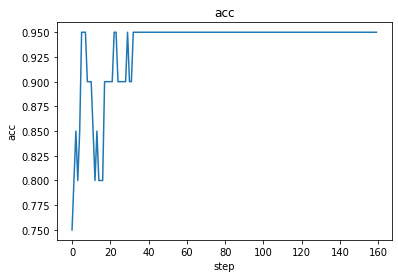

In [8]:
plt.plot(acc.acc)
plt.title('acc')
plt.xlabel('step')
plt.ylabel('acc')

## 预测

In [9]:
predict = np.argmax(ms.ops.Softmax()(model.predict(ms.Tensor(test_x))), axis=1)
corr = model.eval(test_loader, dataset_sink_mode=False)
print(corr)

{'Acc': 0.95}
